
# Modelos de Linguagem — **Parte 2**  
## Encoder–Decoder, Atenção e Fundamentos de Transformers

### Objetivos
- Entender **por que** RNN/LSTM têm limitações e como a **Atenção** resolve isso.
- Implementar **atenção escalada** com NumPy e **interpretar** seus pesos.
- Diferenciar **self-attention**, **masked attention** (causal) e **encoder–decoder attention**.
- Compreender **Positional Encoding**, **Multi-Head Attention**, **FFN**, **LayerNorm** e **residuais**.
- Conectar esses blocos aos **objetivos de pré-treino** (MLM, CLM, Denoising) e às **arquiteturas** (BERT, GPT, T5).



## 1) Recapitulando RNN/LSTM e motivando a Atenção

**RNN** processa token por token propagando um estado oculto. **LSTM** adiciona portas para reter/descartar informação.  
**Limitações que motivam a Atenção:**
1. **Dependências longas**: difícil associar tokens distantes.  
2. **Baixo paralelismo**: processamento sequencial (treino lento).  
3. **Gargalo de contexto** no seq2seq clássico: um **único vetor** resumindo toda a entrada.

**Ideia-chave da Atenção**: em vez de depender de um único vetor ou de passos sequenciais, permita que cada posição **“olhe” diretamente** para **todas** as outras posições relevantes.



## 2) Encoder–Decoder clássico (com RNNs) — onde dói?

<br/>
<img src="https://raw.githubusercontent.com/bmnogueira-ufms/TopicosIA-2025-02/main/images/encoder_decoder_2.png" width="50%">

- **Encoder** lê a sequência de entrada e gera um **vetor de contexto** (estado final).  
- **Decoder** usa aquele vetor para gerar a saída, **um token por vez** (teacher forcing no treino, autoregressivo na inferência).

**Dor**: o vetor de contexto **condensa tudo**; em frases longas, perde detalhes.  
**Solução histórica**: **Atenção** (Bahdanau/Luong) — o decoder pondera **diferentes partes do encoder** a cada passo.



## 3) Intuição da Atenção (ex.: tradução)

Entrada (en): *"The book is on the table"*  
Saída (pt): *"O livro está sobre a mesa"*

Ao gerar **"mesa"**, queremos **focar** em **"table"**, não tanto em **"book"**.  
A Atenção cria **pesos** que dizem **quanto** cada posição da entrada é relevante para a posição atual da saída.


## 4) Da limitação do vetor fixo → à Atenção

Até aqui vimos que:
- No **encoder–decoder clássico com RNN/LSTM**, toda a frase de entrada era “espremida” em um **único vetor de contexto**.
- Esse vetor servia como base para o decoder gerar **cada token da saída**.
- Problema: em frases longas, esse **resumo único** perde informação → o modelo esquece detalhes.

### Ideia da Atenção
Em vez de confiar apenas em um vetor fixo, vamos permitir que o decoder, a cada passo, **escolha em quais partes da entrada prestar atenção**.  
Assim, a representação da saída em `t` não vem só de um vetor fixo, mas de uma **combinação ponderada** de todos os estados do encoder.

### Como formalizamos isso?
1. Cada **palavra da entrada** gera três vetores diferentes:
   - **Query (Q)**: “o que estou procurando agora?”
   - **Key (K)**: “como posso ser encontrado?”
   - **Value (V)**: “qual informação entrego se for relevante?”

   > Esses vetores são obtidos a partir dos embeddings, multiplicados por **matrizes de peso** aprendidas:  
   > `Q = X · W^Q`, `K = X · W^K`, `V = X · W^V`.

2. Para cada **token alvo (query)**, calculamos sua **similaridade** com todos os **tokens fonte (keys)**:  
   - Produto escalar `Q · K^T` → mede quão forte é a correspondência entre consulta e chave.

3. Normalizamos esses scores com **softmax** → viram probabilidades (somam 1).  
   - Se “mesa” busca correspondências, o softmax pode dar peso maior para “table” e menor para “book”.

4. Finalmente, usamos esses pesos para **combinar os valores (V)** correspondentes → obtendo uma nova representação **contextualizada**.

### Fórmula completa
$$
\mathrm{Attention}(Q,K,V) = \mathrm{softmax}\!\left(\frac{QK^\top}{\sqrt{d_k}}\right)V
$$

- O termo $\frac{1}{\sqrt{d_k}}$ evita que os scores fiquem grandes demais em dimensões altas.
- Cada linha do softmax representa **como um token distribui sua atenção pelos outros**.

### Exemplo
Frase de entrada: *“O livro está na mesa”*  
- Quando o decoder gera “table” → query se conecta fortemente à key de “mesa”.  
- O valor correspondente traz a informação semântica de “mesa”.  
- Assim, o modelo não depende mais de um único vetor: ele pode **puxar dinamicamente** a informação relevante de onde precisar.

Esse é o núcleo da atenção: **aprender a focar nas partes certas da entrada, dinamicamente, a cada passo**.


## Ok... Vamos com calma: Query, Key e Value em Mecanismos de Atenção

### De onde vem a ideia?
O mecanismo de atenção foi criado para resolver um problema clássico em redes neurais para sequência (como RNNs e LSTMs):  
quando o texto é longo, o modelo tem dificuldade de **“lembrar”** o que veio antes.  

A ideia da atenção é permitir que, em cada passo da geração, o modelo **olhe de volta** para toda a sequência de entrada e **decida o que é mais relevante** para o próximo passo.

---

### Intuição: perguntas e respostas
Imagine que você está traduzindo uma frase do inglês para o português.  
Quando chega no momento de traduzir a palavra **“bank”**, você precisa saber se “bank” é **banco de sentar** ou **banco financeiro**.  

- Você olha para o resto da frase e pergunta: *“De que tipo de ‘bank’ estamos falando?”*  
- Para responder, você precisa ver o **contexto** das outras palavras.  

É exatamente esse processo que o mecanismo de atenção formaliza, usando **Query, Key e Value**.

---

### O que são Query, Key e Value?

> Intuição rápida: **Q** é a *pergunta* que uma posição faz ao contexto; **K** são *etiquetas/endereços* que cada posição oferece para ser encontrada; **V** é o *conteúdo* que será entregue se aquela posição for considerada relevante.

São apenas **representações vetoriais** (obtidas por multiplicações de matrizes aprendidas) que assumem papéis diferentes:

- **Query (Q)** → é a **pergunta** que a palavra atual está fazendo.  
  > Ex.: a palavra “bank” pergunta: “qual o meu sentido aqui?”

- **Key (K)** → é a **etiqueta** que cada palavra da frase carrega, dizendo em que contextos ela pode ser relevante.  
  > Ex.: a palavra “money” carrega uma “chave” que sinaliza relação com contexto financeiro.

- **Value (V)** → é a **informação de conteúdo** que pode ser usada se aquela palavra for escolhida como relevante.  
  > Ex.: a palavra “money” traz consigo um valor que descreve seu significado numérico/financeiro.

---

### Como funciona a mecânica?
1. Cada palavra é transformada em três vetores (Q, K, V) usando matrizes diferentes treináveis.  
   - Então, uma mesma palavra tem representações distintas dependendo do papel que está cumprindo.

2. Para calcular **atenção**, o modelo:
   - Compara a **Query** da palavra-alvo com todas as **Keys** → isso gera um *score* de relevância.
   - Normaliza esses *scores* com **softmax** (para virarem pesos).
   - Usa esses pesos para combinar os **Values** → formando um vetor de contexto para a palavra-alvo.

---

### Exemplo simplificado
Frase: *“I went to the bank to deposit money”*  

- Para a palavra **“bank”**:  
  - **Query** pergunta → “o que significa bank aqui?”.  
  - **Keys** das outras palavras:
    - “to” → chave de preposição, pouca ajuda.  
    - “deposit” → chave que indica ação financeira.  
    - “money” → chave que indica contexto monetário.  
  - O *score* de atenção será alto para “deposit” e “money”.  

Assim, o **Value** dessas palavras pesa mais na construção do significado de “bank” → e o modelo entende que “bank” aqui é **banco financeiro**.

---

### Resumindo
- **Query**: pergunta da palavra atual.  
- **Key**: etiqueta de cada palavra que indica em quais contextos ela é relevante.  
- **Value**: informação que pode ser usada se a palavra for escolhida.  
- O mecanismo de atenção **casa Queries com Keys** para decidir quais Values importar.

## Query (Q), Key (K) e Value (V) — explicação detalhada

---

### De onde surgem Q, K e V?

Dado um embedding por posição na sequência (matriz **X**), o Transformer aprende **três projeções lineares** diferentes:

$$
Q = X W_Q,\qquad K = X W_K,\qquad V = X W_V
$$

- $X \in \mathbb{R}^{L \times d_{\text{model}}}$ (L = comprimento da sequência)
- $W_Q, W_K \in \mathbb{R}^{d_{\text{model}} \times d_k}$, $W_V \in \mathbb{R}^{d_{\text{model}} \times d_v}$
- Resulta em $Q, K \in \mathbb{R}^{L \times d_k}$ e $V \in \mathbb{R}^{L \times d_v}$

<br/>
<img src="https://raw.githubusercontent.com/bmnogueira-ufms/TopicosIA-2025-02/main/images/self-attention-matrix-calculation.png" width="50%">

Fonte: https://jalammar.github.io/illustrated-transformer/

> Por que **três** projeções?  
> Para **separar papéis**: “endereçar/buscar” (Q, K) e “transportar conteúdo” (V). O modelo pode aprender um *espaço de busca* (Q/K) diferente do *espaço de conteúdo* (V).

---

### O papel específico de cada um

#### Query (Q) — *a pergunta da posição atual*
- Representa **o que essa posição precisa do contexto**.
- É comparada **contra todas as Keys** para descobrir onde há informação útil.
- Mental model: “estou na palavra *bank*; minha Query pergunta ‘qual o meu sentido aqui?’”.

#### Key (K) — *a etiqueta/assinatura de cada posição*
- Descreve **em quais perguntas** essa posição deve ser considerada.
- Funciona como **endereço** para ser *match* com Queries.
- Mental model: a palavra *money* carrega uma Key com “cheiro” de finanças.

#### Value (V) — *o conteúdo a ser entregue*
- É **a informação que realmente será combinada** para formar o contexto final.
- Se uma Key tem alto *match* com a Query, **o Value correspondente** entra com peso maior na composição.
- Mental model: o Value de *money* contém o conteúdo semântico “financeiro” útil para desambiguar *bank*.

<br/>
<img src="https://raw.githubusercontent.com/bmnogueira-ufms/TopicosIA-2025-02/main/images/self_attention.png" width="50%">

Fonte: https://jalammar.github.io/illustrated-transformer/

---

### Como Q, K e V interagem (o “cálculo da atenção”)

1. **Similaridade** (relevância) entre cada Query e todas as Keys:
   $$
   S = \frac{QK^\top}{\sqrt{d_k}}
   $$
   A divisão por $\sqrt{d_k}$ estabiliza a escala dos *scores*, evitando *softmax* saturado e gradientes ruins.

   <br/>
<img src="https://raw.githubusercontent.com/bmnogueira-ufms/TopicosIA-2025-02/main/images/self_attention_score.png" width="50%">

Fonte: https://jalammar.github.io/illustrated-transformer/


2. **Normalização** para virar pesos de atenção:
   $$
   A = \mathrm{softmax}(S)\quad \text{(por linha)}
   $$
  
  <br/>
<img src="https://raw.githubusercontent.com/bmnogueira-ufms/TopicosIA-2025-02/main/images/self-attention_softmax.png" width="50%">

Fonte: https://jalammar.github.io/illustrated-transformer/

3. **Combinação de conteúdos** (aplica pesos nos Values):
   $$
   \text{Contexto} = A\,V
   $$

   <br/>
<img src="https://raw.githubusercontent.com/bmnogueira-ufms/TopicosIA-2025-02/main/images/self-attention-matrix-calculation-2.png" width="50%">

Fonte: https://jalammar.github.io/illustrated-transformer/

> Resultado: cada posição recebe um **vetor de contexto** que é uma **soma ponderada dos Values**, onde os pesos vêm de quanto sua Query combinou com as Keys alheias.
   <br/>
<img src="https://raw.githubusercontent.com/bmnogueira-ufms/TopicosIA-2025-02/main/images/self-attention-output.png" width="50%">

Fonte: https://jalammar.github.io/illustrated-transformer/

---

### Onde Q/K/V são obtidos (autoatenção vs. atenção cruzada)

- **Self-attention (autoatenção)**: Q, K e V são **derivados da mesma sequência** (mesmo $X$).  
  → Cada posição olha para **todas** as posições (às vezes com máscara causal).

- **Cross-attention (encoder–decoder)**:  
  **Q** vem do **decoder**, enquanto **K** e **V** vêm do **encoder**.  
  → As Queries do que está sendo gerado consultam as Keys/Values da entrada codificada.

---

### Multi-head (por que várias cópias de Q/K/V?)

Em atenção multi-cabeças, o modelo cria **múltiplos conjuntos** $(W_Q^{(h)}, W_K^{(h)}, W_V^{(h)})$ para cabeças $h=1..H$.  
Cada cabeça aprende:
- um **espaço de busca** (Q/K) próprio,
- e um **espaço de conteúdo** (V) próprio,

permitindo capturar **relações complementares** (sintaxe, dependências longas, co-referência, etc.).  
As saídas das cabeças são **concatenadas** e projetadas novamente.

---

### Por que separar **Key** e **Value**?

- **Desacoplamento “endereço vs. conteúdo”**:  
  é útil “localizar” itens (via Q↔K) num espaço e “transportar” informação (V) em outro.
- **Flexibilidade**: o que torna um token **relevante** nem sempre é o mesmo que deve ser **copiado/transportado**.  
  (Ex.: uma palavra pode ser um ótimo *indicador* de contexto, mas o conteúdo a combinar vem de outra distribuição semântica.)

---

### Dimensões e máscaras

- Em lote e multi-head, formas comuns:
  - $Q, K, V \in \mathbb{R}^{B \times H \times L \times d_k}$ (ou $d_v$ para V)
- **Máscaras** entram somando-se a $S$ antes do softmax:
  - **Padding mask**: ignora *pads*.  
  - **Causal mask** (no decoder): impede “olhar para o futuro”.

---

### Resumo
- **Q**: descreve *o que* a posição quer do contexto (**pergunta**).  
- **K**: descreve *quando/para quem* uma posição deve ser considerada (**endereço**).  
- **V**: fornece *o que será entregue* se aquela posição for escolhida (**conteúdo**).  
- **Atenção**: usa Q↔K para gerar pesos e **mistura V** conforme a relevância.

In [1]:

import numpy as np

def softmax(x, axis=-1):
    """Softmax estável numericamente."""
    x = x - np.max(x, axis=axis, keepdims=True)
    e = np.exp(x)
    return e / np.sum(e, axis=axis, keepdims=True)

def scaled_dot_product_attention(Q, K, V, mask=None):
    """Implementação didática da atenção escalada por produto escalar.

    Q: (B, Tq, d_k)
    K: (B, Tk, d_k)
    V: (B, Tk, d_v)
    mask: (B, Tq, Tk) booleana (True = posição mascarada)
    """
    d_k = Q.shape[-1]
    scores = Q @ K.transpose(0, 2, 1) / np.sqrt(d_k)  # (B, Tq, Tk)
    if mask is not None:
        # coloca -inf (aprox -1e9) nas posições inválidas
        scores = np.where(mask, -1e9, scores)
    weights = softmax(scores, axis=-1)                # (B, Tq, Tk)
    return weights @ V, weights                       # saída: (B, Tq, d_v), pesos: (B, Tq, Tk)

# Demonstração mínima
np.random.seed(123)
B, T, d = 1, 4, 6
X = np.round(np.random.randn(B, T, d), 2)  # "embeddings" de exemplo

# Projeções lineares para Q, K, V (didático; pesos aleatórios fixos)
Wq = np.round(np.random.randn(d, d), 2)
Wk = np.round(np.random.randn(d, d), 2)
Wv = np.round(np.random.randn(d, d), 2)

Q = np.round(X @ Wq, 2)
K = np.round(X @ Wk, 2)
V = np.round(X @ Wv, 2)

print("X shape:", X.shape, "\nX =\n", X)
print("\nQ shape:", Q.shape, "\nQ =\n", Q)
print("\nK shape:", K.shape, "\nK =\n", K)
print("\nV shape:", V.shape, "\nV =\n", V)

out, att = scaled_dot_product_attention(Q, K, V, mask=None)
print("\nPesos de atenção (att) shape:", att.shape, "\natt =\n", np.round(att, 2))
print("\nSaída (out) shape:", out.shape, "\nout =\n", np.round(out, 2))


X shape: (1, 4, 6) 
X =
 [[[-1.09  1.    0.28 -1.51 -0.58  1.65]
  [-2.43 -0.43  1.27 -0.87 -0.68 -0.09]
  [ 1.49 -0.64 -0.44 -0.43  2.21  2.19]
  [ 1.    0.39  0.74  1.49 -0.94  1.18]]]

Q shape: (1, 4, 6) 
Q =
 [[[ 1.17 -2.3  -1.31  4.44 -1.29  1.89]
  [ 2.82  1.52 -2.07  4.69 -4.49  0.06]
  [ 0.7   7.58  1.83 -0.27  5.66 -0.01]
  [-2.82 -1.22  2.34  1.53  3.32  0.42]]]

K shape: (1, 4, 6) 
K =
 [[[ 4.56 -0.43 -3.31  5.63 -5.47 -1.37]
  [ 4.16 -0.96 -3.55  5.78 -7.   -2.68]
  [ 0.5  -2.69  0.4  -2.36  5.15  4.06]
  [ 0.5  -2.99  1.05  1.02  1.41  2.66]]]

V shape: (1, 4, 6) 
V =
 [[[ 1.98  4.35  2.22 -0.07 -6.27  1.85]
  [ 2.1   0.23 -0.39  2.31 -5.28  8.29]
  [-1.53 -3.22  2.65 -0.56  1.69 -4.11]
  [ 2.24 -0.01 -1.55 -1.31  0.39 -6.4 ]]]

Pesos de atenção (att) shape: (1, 4, 4) 
att =
 [[[0.38 0.62 0.   0.  ]
  [0.08 0.92 0.   0.  ]
  [0.   0.   1.   0.  ]
  [0.   0.   0.92 0.08]]]

Saída (out) shape: (1, 4, 6) 
out =
 [[[ 2.05  1.78  0.59  1.41 -5.65  5.86]
  [ 2.09  0.55 -0.19  2.

In [8]:
# Demonstração passo a passo de ATENÇÃO (encoder–decoder) com matrizes pequenas e prints didáticos
import numpy as np

np.set_printoptions(suppress=True, linewidth=120, precision=3)

# 0) Sequências e tokens (exemplo de tradução simples)
src_tokens = ["o", "livro", "está", "na", "mesa"]   # entrada (encoder)
# passo atual do decoder (vamos supor que estamos para gerar "table" em inglês, consultando a entrada em pt)
tgt_step_token = "table(?)"  # "palavra-alvo" que o decoder está tentando gerar agora

print("Entrada (encoder):", src_tokens)
print("Token alvo (decoder, passo t):", tgt_step_token, "\n")

# 1) Embeddings simples e pesos de projeção (didáticos, aleatórios mas fixos)
rng = np.random.default_rng(110)
d_model = 8   # dimensão "do mundo" (pequena pra caber na tela)
d_k = 8       # para simplificar, d_k = d_model
d_v = 8

# embeddings da entrada (encoder) – 1 vetor por token
X_src = rng.normal(size=(1, len(src_tokens), d_model))

# embedding do estado atual do decoder (p.ex., a palavra anterior + contexto do decoder)
# para a narrativa, vamos usar um vetor que representa "o que estou tentando gerar" (uma query)
y_t = rng.normal(size=(1, 1, d_model))

# matrizes de projeção treináveis (aqui, só para demonstração)
WQ_dec = rng.normal(size=(d_model, d_k))  # Q vem do decoder
WK_enc = rng.normal(size=(d_model, d_k))  # K vem do encoder
WV_enc = rng.normal(size=(d_model, d_v))  # V vem do encoder

# 2) Projeções: Q do decoder, K e V do encoder
Q = y_t @ WQ_dec           # (1, 1, d_k)
K = X_src @ WK_enc         # (1, T_src, d_k)
V = X_src @ WV_enc         # (1, T_src, d_v)

print("FORMAS (shapes):")
print("Q (decoder):", Q.shape, "| K (encoder):", K.shape, "| V (encoder):", V.shape, "\n")

# 3) Scores de atenção (similaridade) entre a "consulta" do decoder (Q) e todas as "chaves" do encoder (K)
#    S = Q K^T / sqrt(d_k)  → aqui temos apenas 1 query (passo t do decoder), então S: (1, 1, T_src)
scores = (Q @ np.transpose(K, (0, 2, 1))) / np.sqrt(d_k)  # (1, 1, T_src)

# 4) Softmax nos scores para virar distribuição de probabilidade sobre os tokens de entrada
def softmax(x, axis=-1):
    x = x - np.max(x, axis=axis, keepdims=True)  # estabilidade numérica
    e = np.exp(x)
    return e / np.sum(e, axis=axis, keepdims=True)

attn_weights = softmax(scores, axis=-1)  # (1, 1, T_src)

# 5) Combinação convexa dos VALORES (V): O = A · V  → saída contextualizada que o decoder usará para prever o próximo token
O = attn_weights @ V  # (1, 1, d_v)

print("SCORES (antes do softmax) para cada token da ENTRADA (ordem =", src_tokens, "):")
print(scores.reshape(-1), "\n")

print("PESOS DE ATENÇÃO (após softmax) – somam ~1 na linha:")
print(np.round(attn_weights.reshape(-1), 3))
print("Soma:", float(np.sum(attn_weights)), "\n")

# 6) Interpretabilidade: listar tokens de entrada por atenção decrescente (top-k)
top_idx = np.argsort(-attn_weights.reshape(-1))
print("Ordem de relevância (do mais atendido ao menos):")
for rank, j in enumerate(top_idx.tolist(), start=1):
    print(f"{rank:>2}. token='{src_tokens[j]}'  peso={attn_weights.reshape(-1)[j]:.3f}")

print("\nSAÍDA CONTEXTUALIZADA (O) que o decoder usaria para prever o próximo token:")
print(np.round(O.reshape(-1), 3))

# 7) (Opcional) Efeito da normalização por sqrt(d_k):
scores_no_scale = (Q @ np.transpose(K, (0, 2, 1)))  # sem dividir por sqrt(d_k)
attn_no_scale = softmax(scores_no_scale, axis=-1)
print("\n[Diagnóstico] Sem dividir por sqrt(d_k), os pesos (softmax) ficam:")
print(np.round(attn_no_scale.reshape(-1), 3), " (pode saturar em d_k grandes)")

# 8) Sanidade: verificar que a soma dos pesos é 1 (distribuição)
assert np.allclose(np.sum(attn_weights, axis=-1), 1.0, atol=1e-6), "Softmax não somou 1 (algo errado)."

# 9) Resumo textual final (conectando com a narrativa)
print("\nResumo:")
print(f"- Temos 1 consulta (decoder, para gerar '{tgt_step_token}') e {len(src_tokens)} chaves/valores (encoder).")
print("- Calculamos similaridade Q·K^T/√d_k, aplicamos softmax → isso diz QUANTO olhar para cada palavra da entrada.")
print("- Com esses pesos, combinamos os VALORES (V) da entrada para construir uma representação contextualizada (O).")
print("- O substitui o 'vetor fixo' do seq2seq clássico: agora o decoder puxa DINAMICAMENTE a informação relevante da entrada.")

Entrada (encoder): ['o', 'livro', 'está', 'na', 'mesa']
Token alvo (decoder, passo t): table(?) 

FORMAS (shapes):
Q (decoder): (1, 1, 8) | K (encoder): (1, 5, 8) | V (encoder): (1, 5, 8) 

SCORES (antes do softmax) para cada token da ENTRADA (ordem = ['o', 'livro', 'está', 'na', 'mesa'] ):
[ 4.636 -3.248  5.583 -6.994 -4.55 ] 

PESOS DE ATENÇÃO (após softmax) – somam ~1 na linha:
[0.28 0.   0.72 0.   0.  ]
Soma: 0.9999999999999999 

Ordem de relevância (do mais atendido ao menos):
 1. token='está'  peso=0.720
 2. token='o'  peso=0.280
 3. token='livro'  peso=0.000
 4. token='mesa'  peso=0.000
 5. token='na'  peso=0.000

SAÍDA CONTEXTUALIZADA (O) que o decoder usaria para prever o próximo token:
[ 6.042  4.388 -2.767  0.136  1.298 -1.439  1.153 -4.01 ]

[Diagnóstico] Sem dividir por sqrt(d_k), os pesos (softmax) ficam:
[0.064 0.    0.936 0.    0.   ]  (pode saturar em d_k grandes)

Resumo:
- Temos 1 consulta (decoder, para gerar 'table(?)') e 5 chaves/valores (encoder).
- Calculamos si


### 4.1) Visualizando pesos de atenção com tokens (mini-demo)

Vamos usar uma frase curta. Atribuiremos embeddings artificiais (aleatórios) apenas para **visualização**.  
**Objetivo**: ver a **matriz de atenção** (quem olha para quem).


Matriz de atenção (linhas = tokens consultando; colunas = tokens atendidos):

[[0.   0.   0.   1.  ]
 [0.77 0.   0.   0.23]
 [0.71 0.28 0.   0.  ]
 [0.1  0.9  0.   0.  ]]


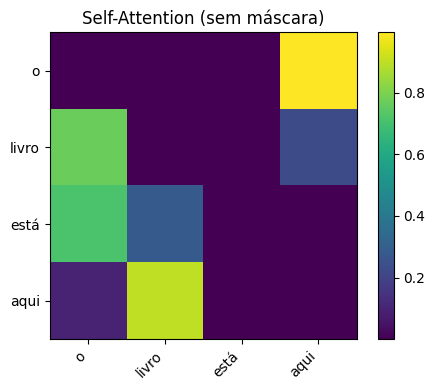

In [7]:

import numpy as np
import matplotlib.pyplot as plt

def attention_heatmap(tokens, att_matrix, title="Pesos de Atenção"):
    """Mostra um heatmap simples dos pesos de atenção (T x T).
    tokens: lista de strings (tamanho T)
    att_matrix: (T, T) para um único exemplo/consulta
    """
    plt.figure(figsize=(5,4))
    plt.imshow(att_matrix)
    plt.colorbar()
    plt.xticks(range(len(tokens)), tokens, rotation=45, ha='right')
    plt.yticks(range(len(tokens)), tokens)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Frase simples
tokens = ["o", "livro", "está", "aqui"]
T = len(tokens)
d = 8

np.random.seed(7)
X = np.random.randn(1, T, d)  # embeddings aleatórios
Wq = np.random.randn(d, d); Wk = np.random.randn(d, d); Wv = np.random.randn(d, d)
Q = X @ Wq; K = X @ Wk; V = X @ Wv

def softmax(x, axis=-1):
    x = x - np.max(x, axis=axis, keepdims=True)
    e = np.exp(x)
    return e / np.sum(e, axis=axis, keepdims=True)

d_k = d
scores = (Q @ K.transpose(0,2,1)) / np.sqrt(d_k)   # (1, T, T)
weights = softmax(scores, axis=-1)[0]              # (T, T) – sem máscara

print("Matriz de atenção (linhas = tokens consultando; colunas = tokens atendidos):\n")
print(np.round(weights, 2))

attention_heatmap(tokens, weights, title="Self-Attention (sem máscara)")
